In [27]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(ROOT_DIR)

from utils.utils import mse

from utils.problem import MitsubaProblem
from utils.problems.bunny import BunniesProblem

from utils.global_opt.boleap import BOLeap
from utils.global_opt.grad import GlobalOptGrad, RandomStartGrad
from utils.global_opt.utils import IterationStoppingCriteria, NotImprovingStoppingCriteria

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE

from pymoo.operators.crossover.pntx import SinglePointCrossover

mi.set_variant('cuda_ad_rgb')

In [2]:
ROOT_DIR

'/home/auguste/mitsuba_global_optimization'

In [3]:
ten_bunnies_pb = BunniesProblem(nb_bunnies=10, colored=False)

In [4]:
img_ref, bm_ref = ten_bunnies_pb.render(seed=0, spp=1024)
bm_ref

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [5]:
loss_fn = lambda img: mse(img, img_ref)
global_opt_grad = GlobalOptGrad(ten_bunnies_pb)
random_start_grad = RandomStartGrad(ten_bunnies_pb)
boleap_opt = BOLeap(ten_bunnies_pb)

In [6]:
def plot_final_result(best_ind, losses: dict, pb: MitsubaProblem, title=None):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    axs[0].imshow(pb.render_individual(best_ind, spp=1024)[1])
    axs[0].axis('off')
    axs[0].set_title('Optimized image')

    axs[1].imshow(bm_ref)
    axs[1].axis('off')
    axs[1].set_title('Reference Image')
    
    # plot loss
    for name, loss in losses.items():
        axs[2].plot(loss, label=name)
    axs[2].set_title('Loss')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Loss')

    if title is not None:
        fig.suptitle(title, fontsize=16)

    plt.legend()
    plt.show()

In [7]:
def random_start_exp(pop_size, grad_steps, seed=0):
    res, losses, nb_renderings = random_start_grad.run(
        loss_fn,
        pop_size=pop_size,
        grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter=grad_steps),
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {f"{i}" : losses[i] for i in range(len(losses))}
    plot_final_result(res.X, losses_dict, ten_bunnies_pb, title=f'Random start: {pop_size=}, {grad_steps=} - {nb_renderings=}')

In [25]:
def ga_grad_exp(pop_size, n_gen, grad_steps, seed=0):
    res, losses, nb_renderings = global_opt_grad.run(
        GA(pop_size=pop_size, eliminate_duplicates=True, crossover=SinglePointCrossover(prob=0.8)),
        loss_fn,
        n_gen=n_gen,
        grad_descent_stopping_criteria=IterationStoppingCriteria(grad_steps),
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {
        "avg" : [np.mean(l) for l in losses],
        "best" : [np.min(l) for l in losses],
        "worst" : [np.max(l) for l in losses],
    }
    plot_final_result(res.X, losses_dict, ten_bunnies_pb, title=f'Genetic algorithm: {pop_size=}, {n_gen=}, {grad_steps=}  - {nb_renderings=}')

In [9]:
def boleap_exp(pop_size, bo_steps, cmaes_steps, grad_steps, seed=0):
    best_ind, losses, nb_renderings = boleap_opt.run(
        loss_fn,
        bo_steps,
        cmaes_steps,
        grad_steps,
        pop_size=pop_size,
        lr=0.025,
        spp=16,
        seed=seed,
        verbose=True,
    )
    losses_dict = {"grad" : losses}
    plot_final_result(best_ind, losses_dict, ten_bunnies_pb, title=f'BO-Leap: {pop_size=}, {bo_steps=}, {cmaes_steps=}, {grad_steps=}  - {nb_renderings=}')

# Gradient descent from 1 random starting point


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



[Ind. 1/1] Grad step 299	Best loss: 0.005929	Nb renderings: 299: : 1it [01:27, 87.71s/it]


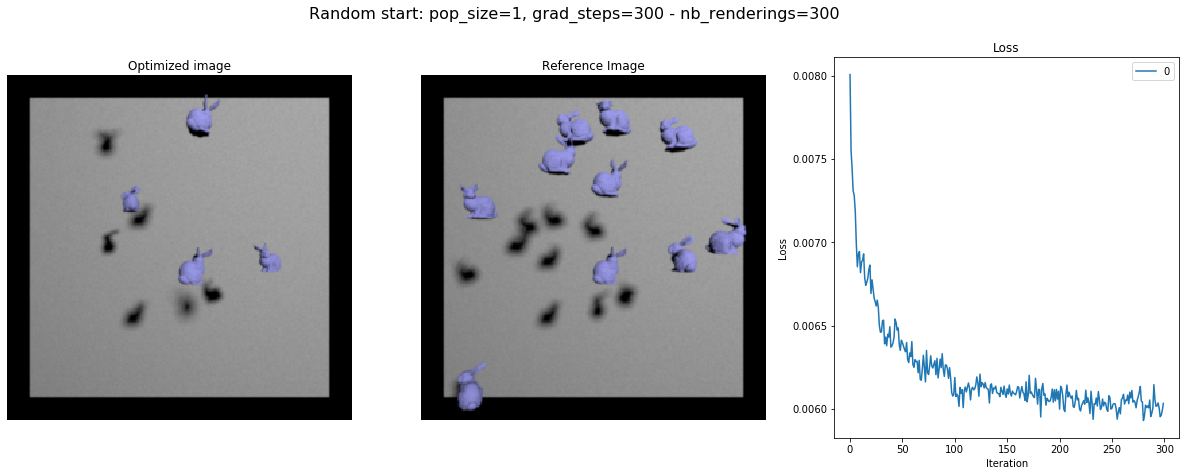

In [10]:
random_start_exp(pop_size=1, grad_steps=300, seed=0)

[Ind. 1/1] Grad step 299	Best loss: 0.006490	Nb renderings: 299: : 1it [01:33, 93.11s/it]


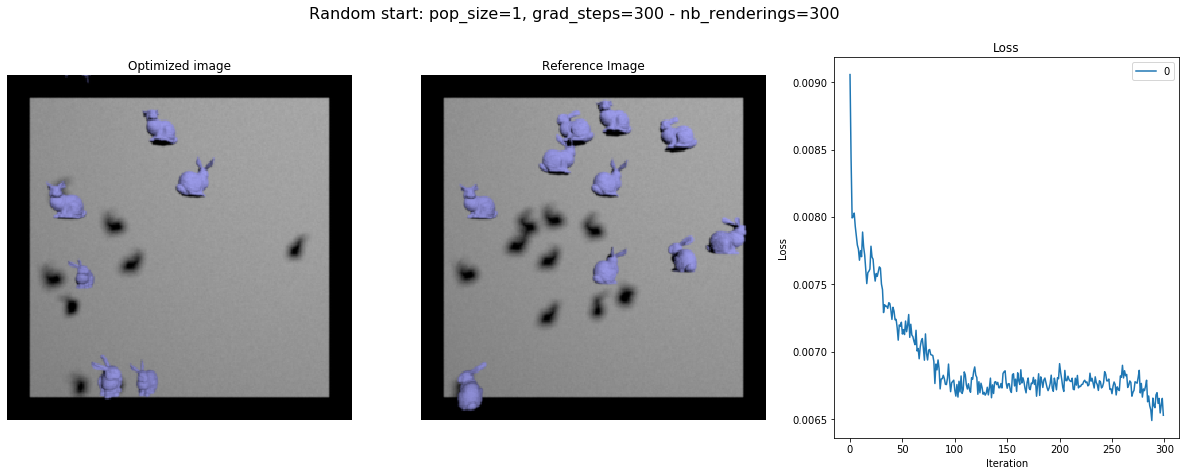

In [11]:
random_start_exp(pop_size=1, grad_steps=300, seed=1)

[Ind. 1/1] Grad step 299	Best loss: 0.006884	Nb renderings: 299: : 1it [01:39, 99.86s/it]


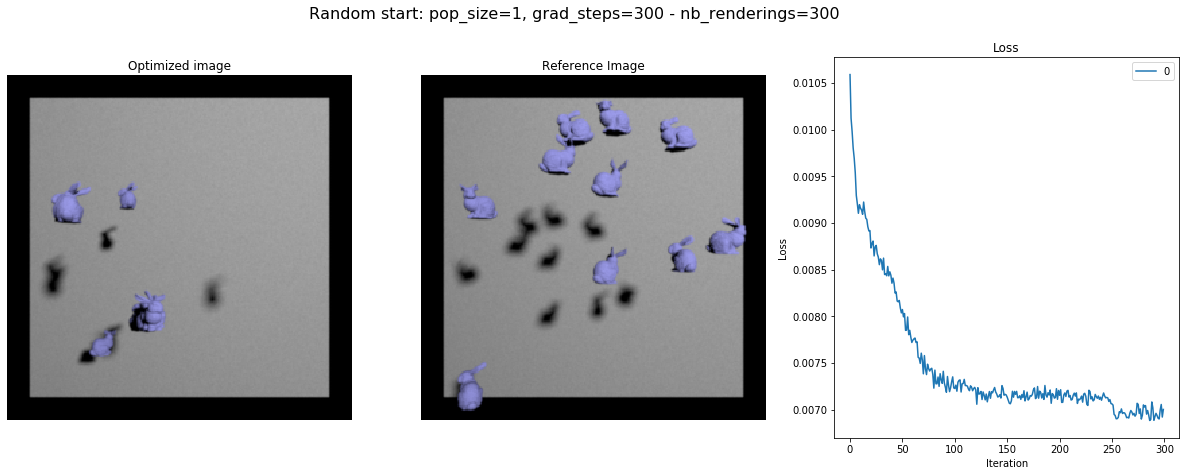

In [12]:
random_start_exp(pop_size=1, grad_steps=300, seed=2)

# Gradient descent from 5 random starting points

[Ind. 5/5] Grad step 59	Best loss: 0.006172	Nb renderings: 299: : 5it [01:47, 21.44s/it]


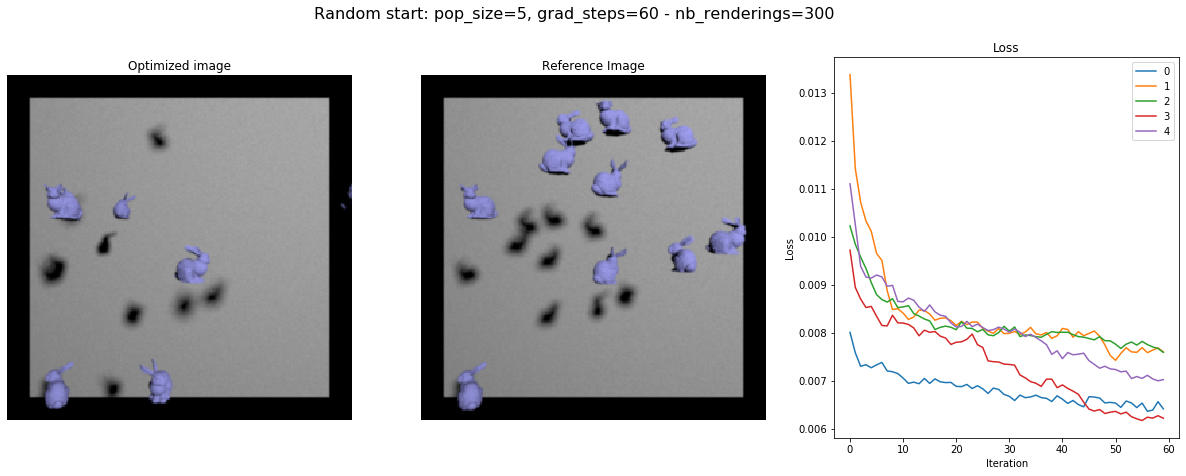

In [13]:
random_start_exp(pop_size=5, grad_steps=60, seed=0)

[Ind. 5/5] Grad step 59	Best loss: 0.006399	Nb renderings: 299: : 5it [01:54, 22.95s/it]


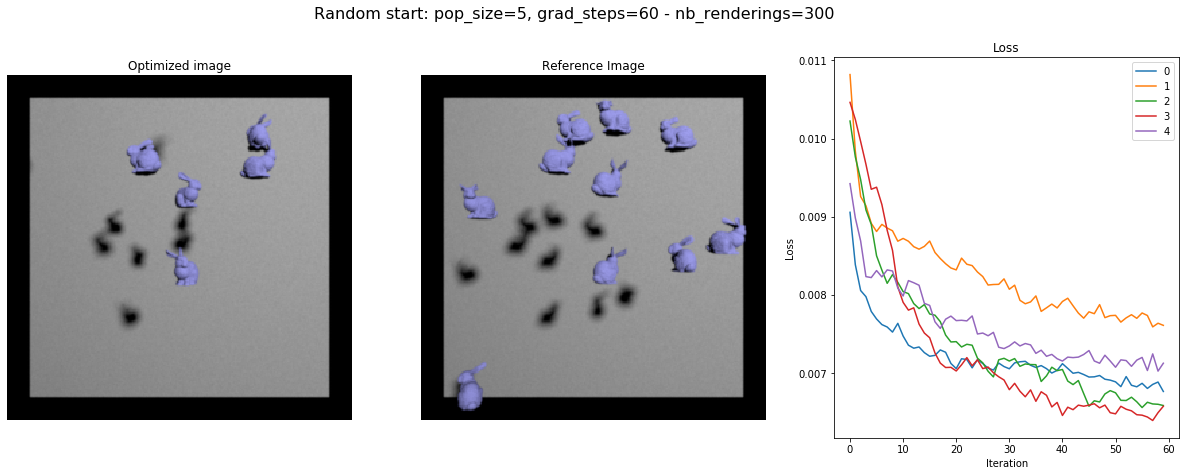

In [14]:
random_start_exp(pop_size=5, grad_steps=60, seed=1)

[Ind. 5/5] Grad step 59	Best loss: 0.006137	Nb renderings: 299: : 5it [02:04, 24.92s/it]


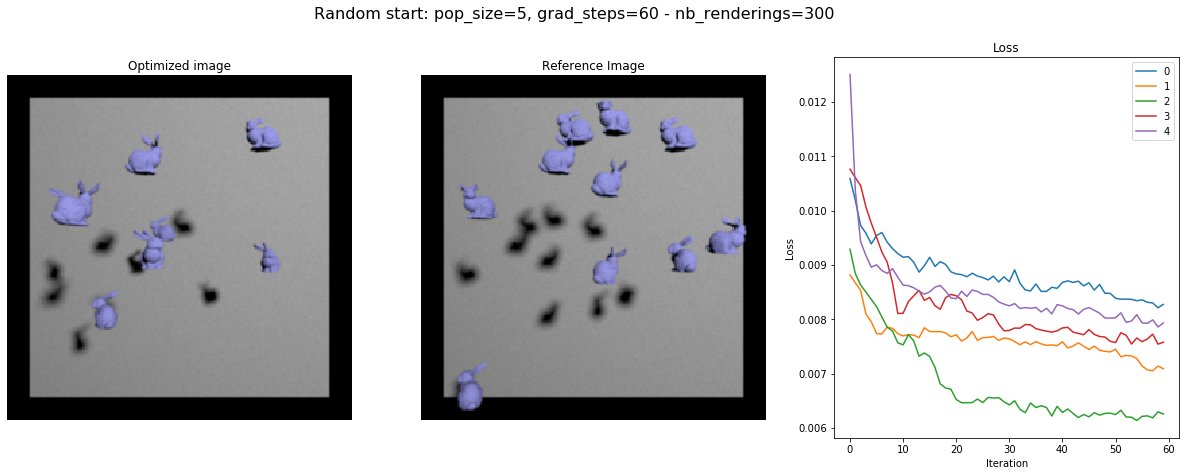

In [15]:
random_start_exp(pop_size=5, grad_steps=60, seed=2)

# Genetic algorithm

[Gen. 15/15] Ind. 20/20	Best loss: 0.007178	Nb renderings: 299: 100%|██████████| 15/15 [01:16<00:00,  5.09s/it]


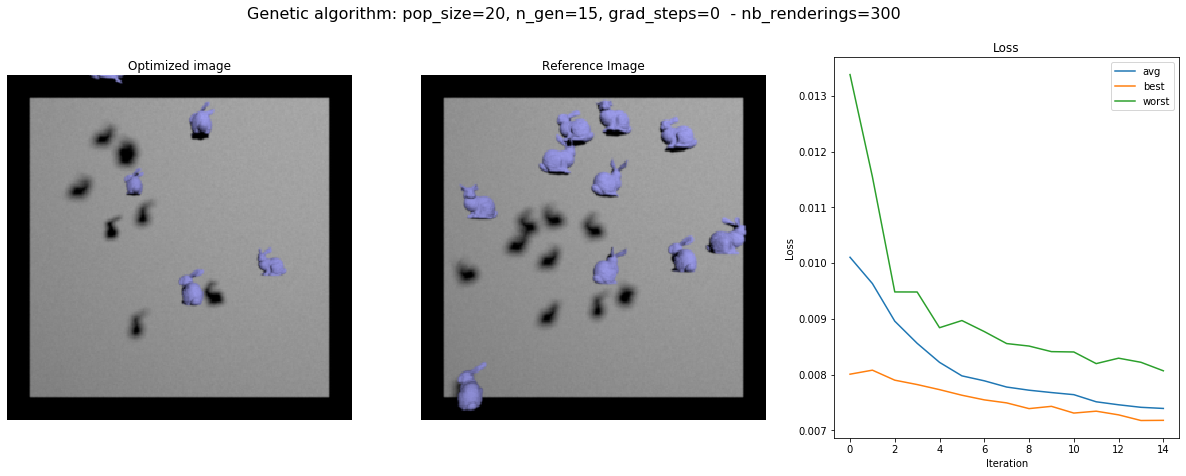

In [28]:
ga_grad_exp(pop_size=20, n_gen=15, grad_steps=0, seed=0)

[Gen. 15/15] Ind. 20/20	Best loss: 0.007275	Nb renderings: 299: 100%|██████████| 15/15 [01:07<00:00,  4.47s/it]


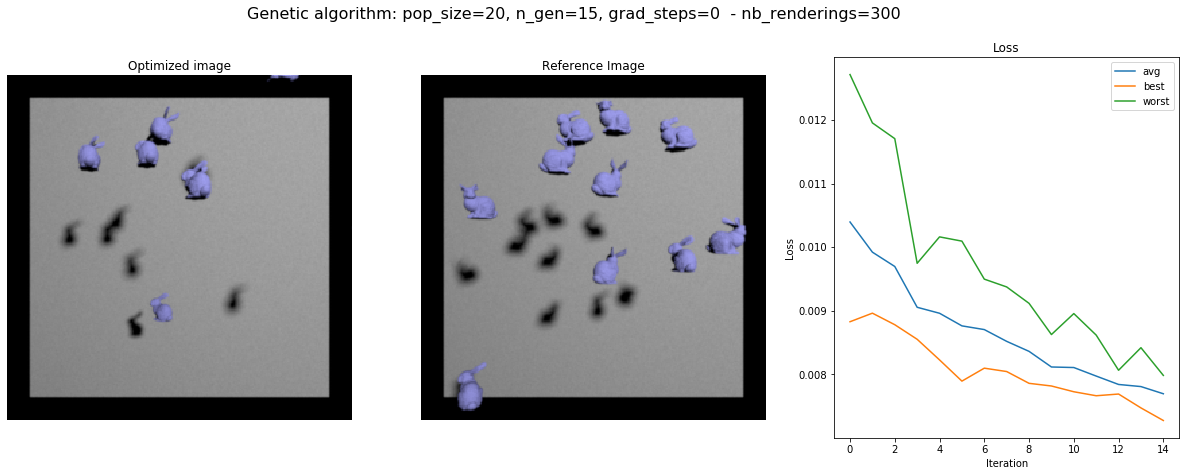

In [17]:
ga_grad_exp(pop_size=20, n_gen=15, grad_steps=0, seed=1)

[Gen. 15/15] Ind. 20/20	Best loss: 0.007297	Nb renderings: 299: 100%|██████████| 15/15 [01:07<00:00,  4.52s/it]


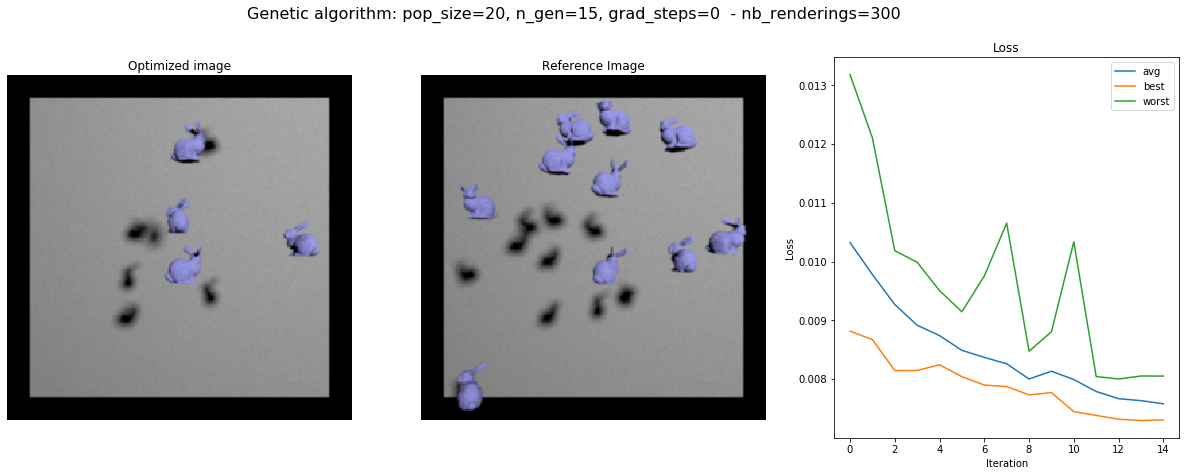

In [18]:
ga_grad_exp(pop_size=20, n_gen=15, grad_steps=0, seed=2)

# Genetic algorithm + gradient descent

[Gen. 10/10] Ind. 10/10	Best loss: 0.006371	Nb renderings: 299: 100%|██████████| 10/10 [02:44<00:00, 16.45s/it]


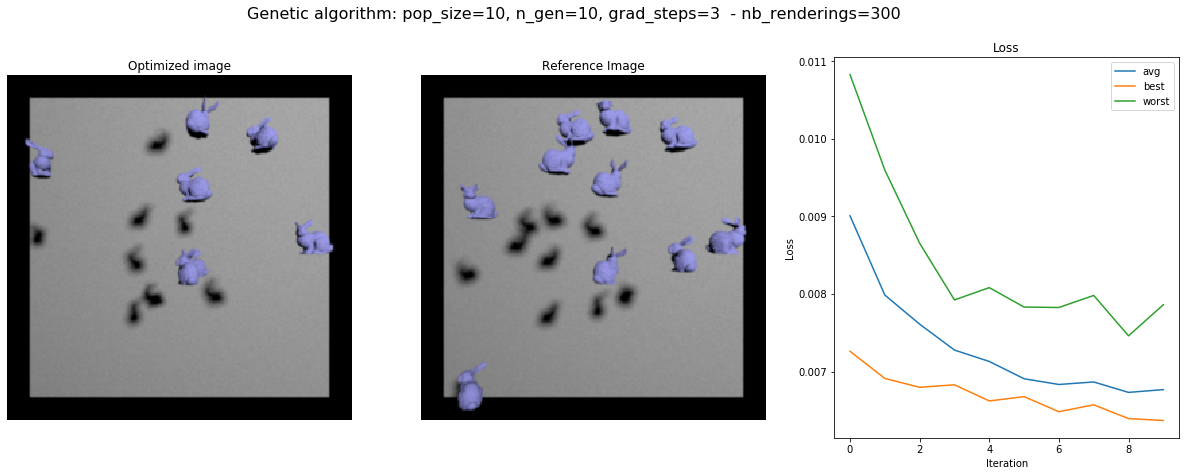

In [29]:
ga_grad_exp(pop_size=10, n_gen=10, grad_steps=3, seed=0)

[Gen. 10/10] Ind. 10/10	Best loss: 0.006205	Nb renderings: 299: 100%|██████████| 10/10 [02:02<00:00, 12.20s/it]


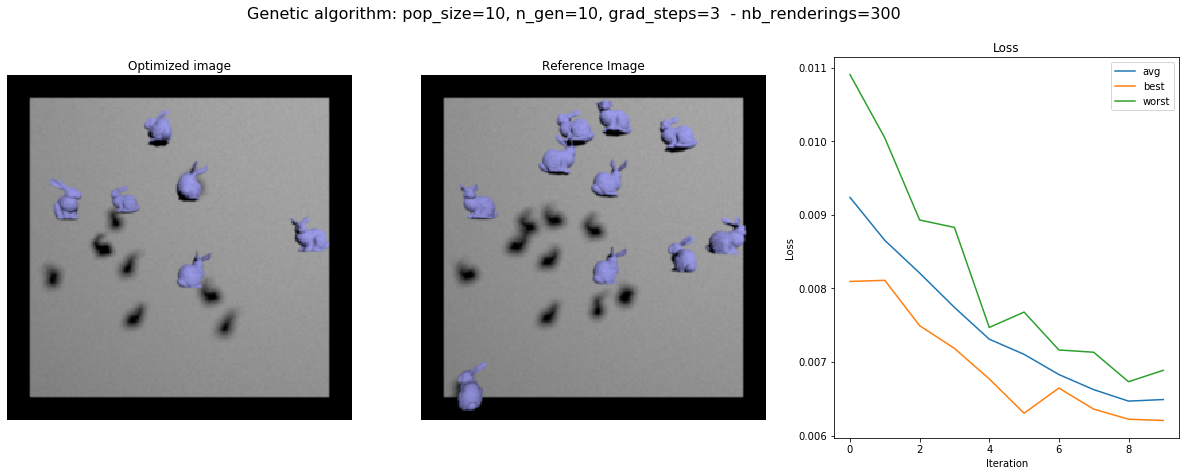

In [20]:
ga_grad_exp(pop_size=10, n_gen=10, grad_steps=3, seed=1)

[Gen. 10/10] Ind. 10/10	Best loss: 0.006671	Nb renderings: 299: 100%|██████████| 10/10 [02:06<00:00, 12.63s/it]


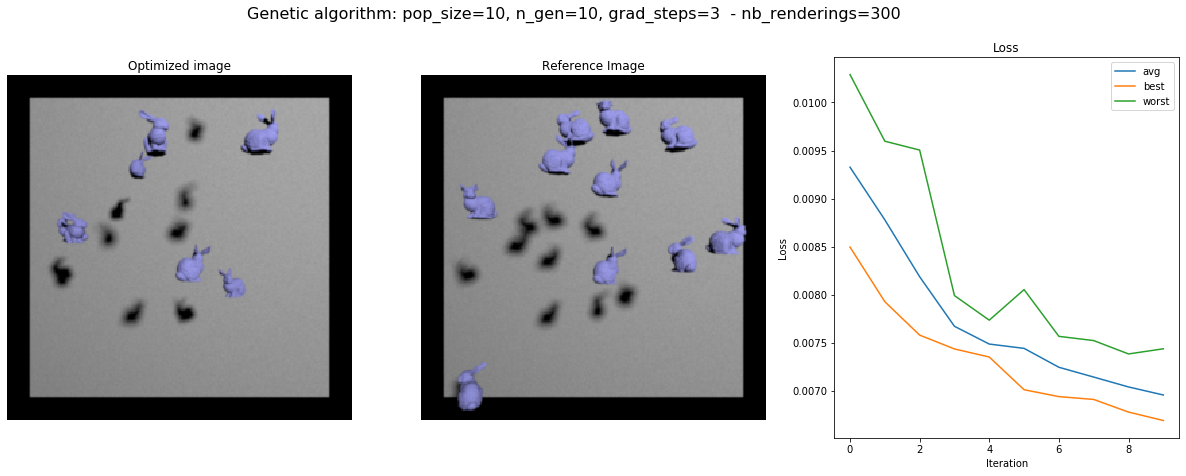

In [21]:
ga_grad_exp(pop_size=10, n_gen=10, grad_steps=3, seed=2)

# BO-Leap

[Step. 1/1 Local step. 3/3 Grad step. 60/60	Best loss: 0.006845	Nb renderings: 300: 100%|██████████| 1/1 [02:26<00:00, 146.97s/it]


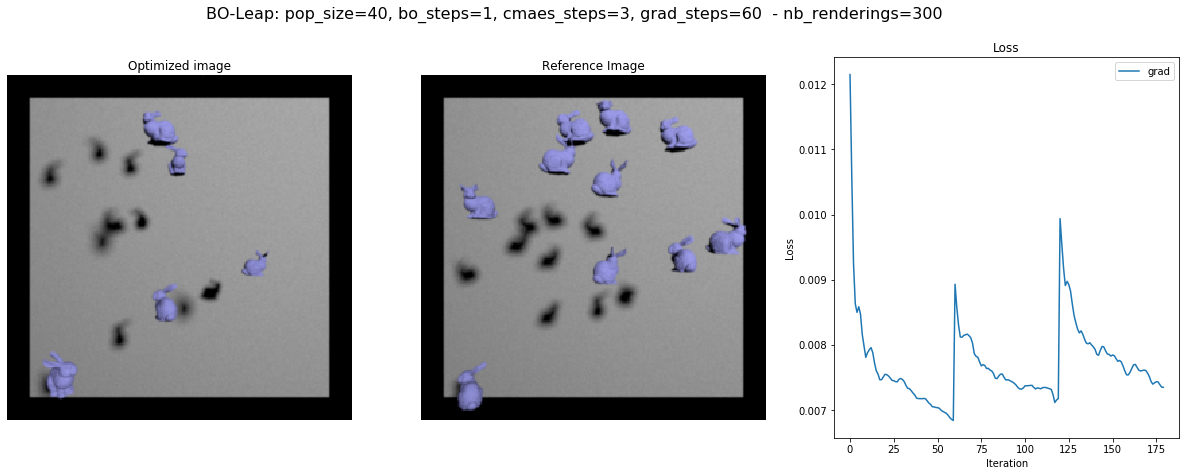

In [22]:
boleap_exp(pop_size=40, bo_steps=1, cmaes_steps=3, grad_steps=60, seed=0)

[Step. 1/1 Local step. 3/3 Grad step. 60/60	Best loss: 0.006212	Nb renderings: 300: 100%|██████████| 1/1 [02:30<00:00, 150.38s/it]


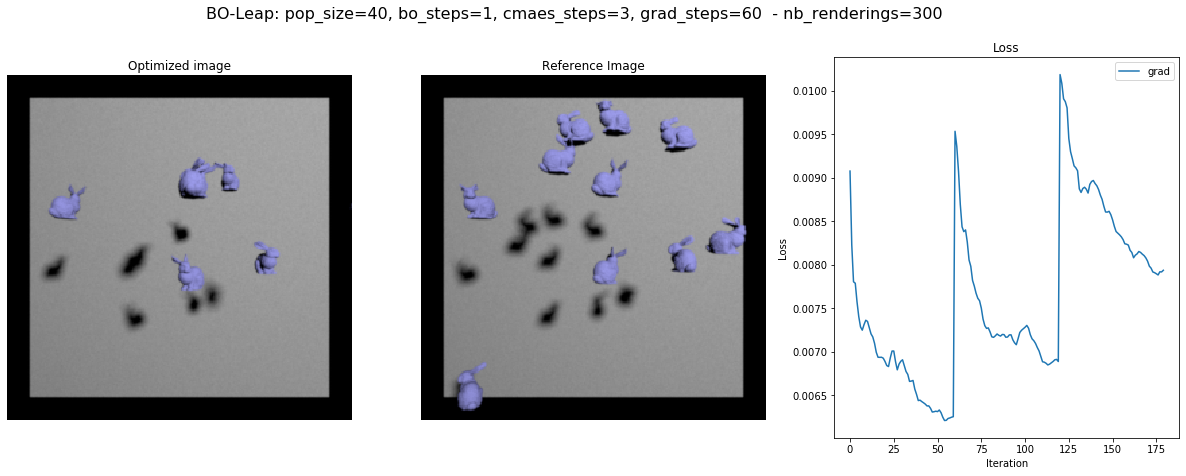

In [23]:
boleap_exp(pop_size=40, bo_steps=1, cmaes_steps=3, grad_steps=60, seed=1)

[Step. 1/1 Local step. 3/3 Grad step. 60/60	Best loss: 0.006390	Nb renderings: 300: 100%|██████████| 1/1 [02:34<00:00, 154.23s/it]


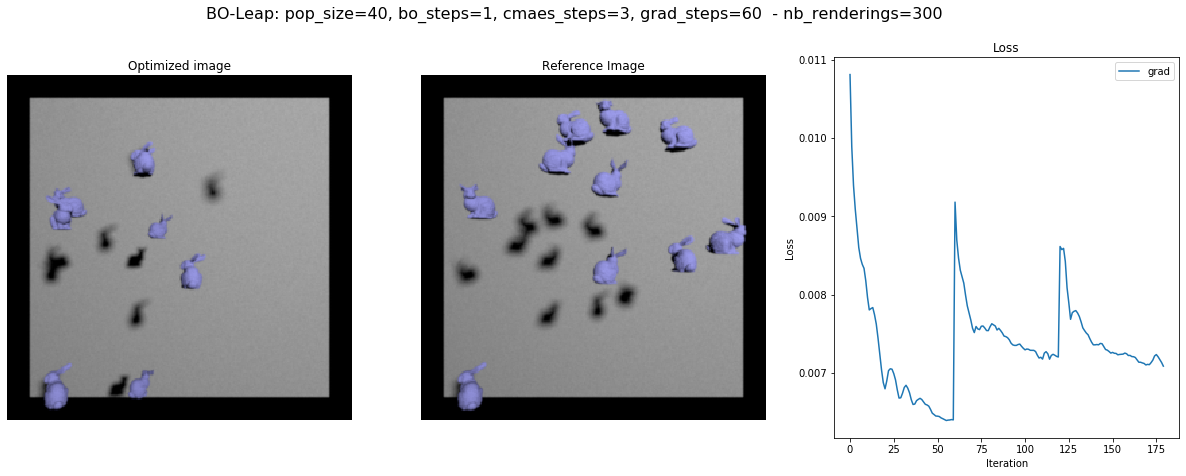

In [24]:
boleap_exp(pop_size=40, bo_steps=1, cmaes_steps=3, grad_steps=60, seed=2)

[Step. 1/1 Local step. 10/10 Ind. 40/40	Best loss: 0.008076	Nb renderings: 400: 100%|██████████| 1/1 [02:25<00:00, 145.70s/it]


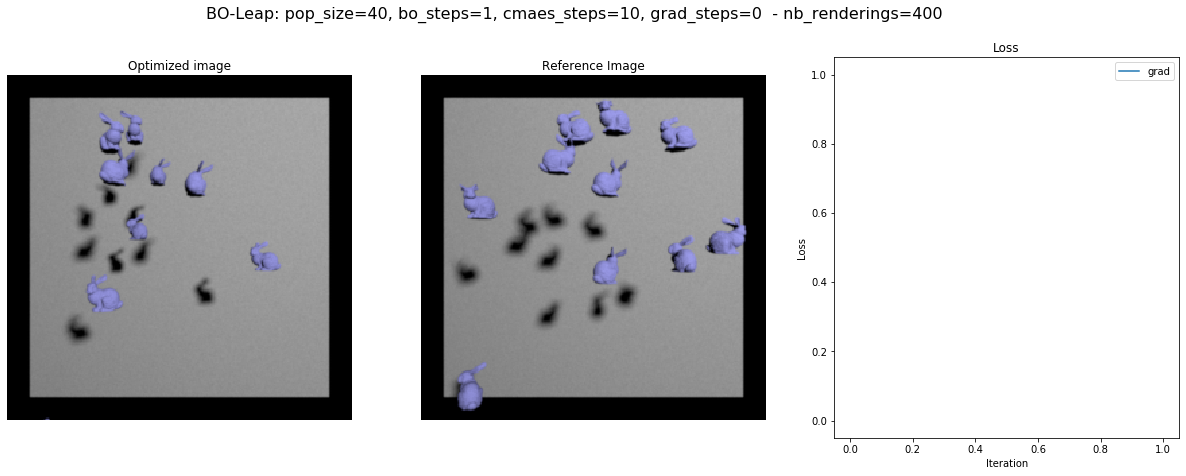

In [30]:
boleap_exp(pop_size=40, bo_steps=1, cmaes_steps=10, grad_steps=0, seed=1)

# Sandbox

In [31]:
def cross_pair(a, b, cross_rate=0.5):
    nb_cross = int(cross_rate * a.shape[0])
    cross_points = list(np.random.choice(a.shape[0], nb_cross, replace=False))
    a, b = np.array(a), np.array(b)
    a[cross_points, ...], b[cross_points, ...] = b[cross_points, ...], a[cross_points, ...]
    return a, b

def mutate(a, mut_rate=0.1):
    if isinstance(a, dict):
        return {key: mutate(val, mut_rate) for (key, val) in a.items()}
    else:
        return np.clip(np.array(a) + np.random.normal(0, mut_rate, a.shape), 0, 1)

from pymoo.operators.sampling.rnd import FloatRandomSampling
from utils.utils import to_float, image_to_bm

def ga_opt(problem: BunniesProblem, pop_size = 10, selection_rate=0.3, mut_rate=0.03, nb_gen = 10, nb_grad_iter = 10, spp=32, seed=0):
    np.random.seed(seed)
    best_image_gen = []
    best_params_gen = []
    best_loss_gen = []

    sampling = FloatRandomSampling()
    param_values = sampling(problem.problem, pop_size).get("X")

    for gen in range(nb_gen):
        print(f"Generation {gen+1}/{nb_gen}")

        losses = []
        new_param_values = []
        img_end = []
        for i, value in enumerate(param_values):
            opt = mi.ad.Adam(lr=0.025)
            for j in range(problem.nb_bunnies):
                opt[f'trans{j}'] = mi.Point2f(value[3*j], value[3*j+1])
                opt[f'angle{j}'] = mi.Float(value[3*j+2])
            scene = problem.reset_scene()
            params = mi.traverse(scene)
            
            for it in range(nb_grad_iter):
                print(f"Sample {i+1}/{pop_size}\tIteration {it+1}/{nb_grad_iter}", end='\r')
                problem.apply_transformations(params, opt)
                img = mi.render(scene, params, seed=seed+i*nb_grad_iter+it, spp=spp)
                loss = dr.sum(dr.sqr(img - img_ref)) / len(img)
                dr.backward(loss)
                opt.step()
            losses.append(to_float(loss))
            values = []
            for j in range(problem.nb_bunnies):
                values.append(to_float(opt[f'trans{j}'].x))
                values.append(to_float(opt[f'trans{j}'].y))
                values.append(to_float(opt[f'angle{j}']))
            new_param_values.append(values)
            img_end.append(img)
        print()


        # handmade genetic algorithm to select the best samples for the next generation
        losses = np.array(losses)
        param_values = np.array(new_param_values)
        idx = np.argsort(losses)

        # print best loss
        print(f"Best loss: {losses[idx[0]]}")

        best_image_gen.append(image_to_bm(img_end[idx[0]]))
        best_params_gen.append(param_values[idx[0]])
        best_loss_gen.append(losses[idx[0]])

        # select the best samples for the next generation and cross them + mutate them
        best_values = [param_values[i] for i in idx[:max(int(pop_size*selection_rate), 1)]]
        new_param_values = []
        for i in range(pop_size):
            a = best_values[np.random.randint(len(best_values))]
            b = best_values[np.random.randint(len(best_values))]
            a, b = cross_pair(a, b)
            a = mutate(a, mut_rate)
            new_param_values.append(a)
        param_values = new_param_values
    
    return best_image_gen, best_params_gen, best_loss_gen

In [32]:
res = ga_opt(ten_bunnies_pb, pop_size=10, selection_rate=0.3, mut_rate=0.03, nb_gen=10, nb_grad_iter=3, spp=16)

Generation 1/10
Sample 10/10	Iteration 3/3
Best loss: 0.007440678309649229
Generation 2/10
Sample 10/10	Iteration 3/3
Best loss: 0.007405929267406464
Generation 3/10
Sample 10/10	Iteration 3/3
Best loss: 0.007069729268550873
Generation 4/10
Sample 10/10	Iteration 3/3
Best loss: 0.006731150206178427
Generation 5/10
Sample 10/10	Iteration 3/3
Best loss: 0.006569938734173775
Generation 6/10
Sample 10/10	Iteration 3/3
Best loss: 0.0065142251551151276
Generation 7/10
Sample 10/10	Iteration 3/3
Best loss: 0.005938884802162647
Generation 8/10
Sample 10/10	Iteration 3/3
Best loss: 0.005899687763303518
Generation 9/10
Sample 10/10	Iteration 3/3
Best loss: 0.005696970038115978
Generation 10/10
Sample 10/10	Iteration 3/3
Best loss: 0.00568991806358099


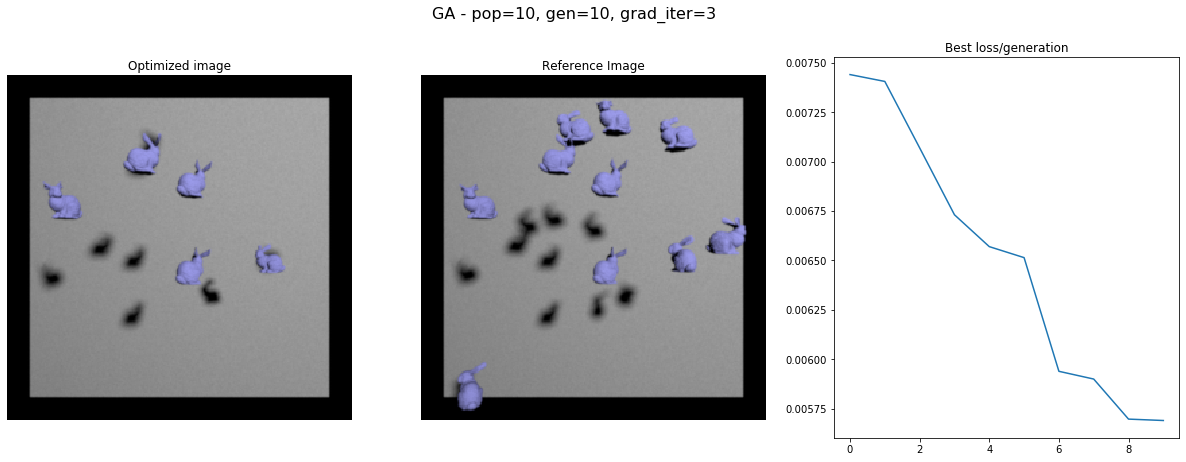

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

axs[0].imshow(ten_bunnies_pb.render_individual(res[1][-1], spp=1024)[1])
axs[0].axis('off')
axs[0].set_title('Optimized image')

axs[1].imshow(bm_ref)
axs[1].axis('off')
axs[1].set_title('Reference Image');

axs[2].plot(res[2])
axs[2].set_title('Best loss/generation');

# figure title
fig.suptitle('GA - pop=10, gen=10, grad_iter=3', fontsize=16);

In [34]:
res_30_10 = ga_opt(ten_bunnies_pb, pop_size=30, selection_rate=0.3, mut_rate=0.03, nb_gen=10, nb_grad_iter=10, spp=16)

Generation 1/10
Sample 30/30	Iteration 10/10
Best loss: 0.0069686779752373695
Generation 2/10
Sample 30/30	Iteration 10/10
Best loss: 0.0061103105545043945
Generation 3/10
Sample 30/30	Iteration 10/10
Best loss: 0.00590004725381732
Generation 4/10
Sample 30/30	Iteration 10/10
Best loss: 0.005876963492482901
Generation 5/10
Sample 30/30	Iteration 10/10
Best loss: 0.005236444529145956
Generation 6/10
Sample 30/30	Iteration 10/10
Best loss: 0.005231940653175116
Generation 7/10
Sample 30/30	Iteration 10/10
Best loss: 0.004757064860314131
Generation 8/10
Sample 30/30	Iteration 10/10
Best loss: 0.004402567632496357
Generation 9/10
Sample 30/30	Iteration 10/10
Best loss: 0.004298266023397446
Generation 10/10
Sample 30/30	Iteration 10/10
Best loss: 0.004338996950536966


: 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

axs[0].imshow(ten_bunnies_pb.render_individual(res_30_10[1][-1], spp=1024)[1])
axs[0].axis('off')
axs[0].set_title('Final image')

axs[1].imshow(bm_ref)
axs[1].axis('off')
axs[1].set_title('Reference Image');

axs[2].plot(res_30_10[2])
axs[2].set_title('Best loss/generation');

# figure title
fig.suptitle('GA - pop=30, gen=10, grad_iter=10', fontsize=16);